In [47]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### Logistic Regression

Suppose that you are the administrator of a university department and you want to determine each applicant’s chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant’s scores on two exams and the admissions decision.
Your task is to build a classification model that estimates an applicant’s probability of admission based the scores from those two exams

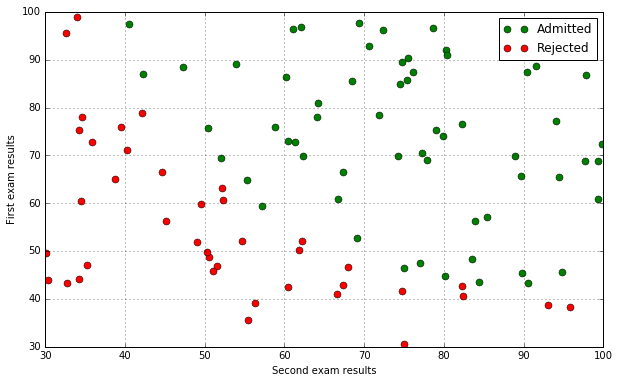

In [48]:
# Load initial data
datafile = 'ex2/ex2data1.txt'
data = np.loadtxt(datafile, delimiter=',', unpack=True)

# Fit data into features and results
X = np.transpose(np.array(data[:-1]))
Y = np.transpose(np.array(data[-1:]))

m = len(Y)
# Add column of 1s.
X = np.insert(X,0,1,axis=1)

#Plot initial data
admitted = np.array([X[i] for i in range(len(Y)) if Y[i] == 1])
rejected = np.array([X[i] for i in range(len(Y)) if Y[i] == 0])

def plot():
    plt.figure(figsize=(10,6))
    plt.plot(admitted[:,1],admitted[:,2],'go',markersize=7, label="Admitted")
    plt.plot(rejected[:,1],rejected[:,2],'ro', markersize=7, label="Rejected")
    plt.ylabel('First exam results')
    plt.xlabel('Second exam results')
    plt.legend(loc='upper right')
    plt.legend()
    plt.grid(True)
    
plot()

### Implementation

##### Sigmoid function

In [49]:
from scipy.special import expit
# sigmoid function is imported from scipy
# sigmoid(0) should be exactly 0.5
print expit(0)

0.5


In [50]:
# hypothesis function for logistic regression
def hypothesis(X, weights):
    return expit(np.dot(X, weights))

##### Cost function and gradient

In [51]:
def compute_cost(weights, X, Y):
    first = np.dot(Y.T, np.log(hypothesis(X, weights)))
    second = np.dot((1-Y).T,np.log(1-hypothesis(X,weights)))
    cost = -(1./m) * (first + second)
    return np.sum(cost)

initial_weights = np.zeros((X.shape[1],1))
compute_cost( initial_weights, X, Y)

0.69314718055994518

#### Finding optimal theta parameters
"You wrote a cost function and calculated its gradient, then took a gradient descent step accordingly. This time, instead of taking gradient descent steps, you will use an Octave/- MATLAB built-in function called fminunc"

Scipy has several alternatives that can find optimum weights and are similar to Octave's fminunc. They are listed here: http://docs.scipy.org/doc/scipy-0.10.0/reference/tutorial/optimize.html

We could use either `fmin` or `fmin_bfgs` (the internet says octave's fminunc is implemented using bfgs).

In [52]:
from scipy.optimize import fmin

def optimize_weights(weights, X, Y):
    result = fmin(compute_cost,x0=weights,args=(X,Y),maxiter=400,full_output=True)
    return result[0],result[1]

In [53]:
optimum_weights, minimum_cost = optimize_weights(initial_weights, X, Y)

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 157
         Function evaluations: 287


In [54]:
"""
Call your costFunction function using the optimal parameters of θ. 
You should see that the cost is about 0.203.
"""
print compute_cost(optimum_weights, X, Y)

0.20349770159


#### Evaluating logistic regression

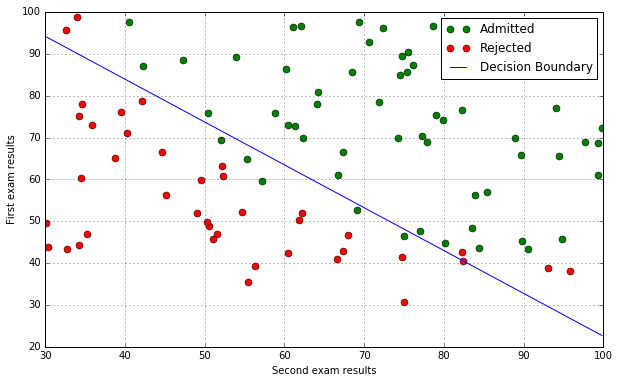

In [55]:
# Initially plot decision boundry
plot_x = np.array([np.min(X[:,1]), np.max(X[:,1])])
plot_y = (-1./optimum_weights[2])*(optimum_weights[0] + optimum_weights[1]*plot_x)
plot()
plt.plot(plot_x,plot_y,'b-',label='Decision Boundary')
plt.legend()

In [56]:
"""
After learning the parameters, you can use the model to predict 
whether a particular student will be admitted. For a student 
with an Exam 1 score of 45 and an Exam 2 score of 85, 
you should expect to see an admission probability of 0.776.
"""
hypothesis([1.,45.,85.],optimum_weights)

0.77629159041124107

In [68]:
def classify_positive(features, weights):
    return hypothesis(features, weights) >= 0.5

def classify_negative(features, weights):
    return hypothesis(features, weights) < 0.5

# How many of the students we know are admitted are classified as positive
correct_positives = np.sum(classify_positive(admitted, optimum_weights))

# How many of the students we know are rejected are classified as negative
correct_negatives = np.sum(classify_negative(rejected, optimum_weights))

total_correct = correct_positives + correct_negatives
total_results = len(admitted) + len(rejected)
correct = float(total_correct) / total_results

print str(correct * 100) + "%"

89.0%
